<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_8_CGAN_MINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import Libraries and Load the MNIST Dataset**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the MNIST dataset
(x_train, y_train), (_, _) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize the images to [-1, 1]
y_train = keras.utils.to_categorical(y_train, 10)  # One-hot encode labels
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(256)



**2.Build the Generator, and Distriminator**

In [ ]:
# Generator model
def build_generator(latent_dim, num_classes=10):
    model = keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_dim=latent_dim + num_classes),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'),
    ])
    return model

# Discriminator model
def build_discriminator(image_shape):
    model = keras.Sequential([
        layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=image_shape),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, kernel_size=5, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1),
    ])
    return model




**3.CGAN model with gradient penalty**

In [ ]:
# CGAN model with gradient penalty
class CGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, num_classes):
        super(CGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.num_classes = num_classes

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(CGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, labels = data
        batch_size = tf.shape(real_images)[0]

        # Generate fake images
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.concat([noise, labels], axis=1)
        generated_images = self.generator(random_latent_vectors, training=True)

        with tf.GradientTape() as disc_tape:
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            d_loss_real = self.loss_fn(tf.ones_like(real_output), real_output)
            d_loss_fake = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = d_loss_real + d_loss_fake

        grads_disc = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_variables))

        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.concat([noise, labels], axis=1)

        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_labels = self.discriminator(generated_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(gen_img_labels), gen_img_labels)

        grads_gen = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads_gen, self.generator.trainable_variables))

        return {'d_loss': d_loss, 'g_loss': g_loss}


**Compile and Train the Model**

In [ ]:
latent_dim = 100
num_classes = 10
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator((28, 28, 1))

cgan = CGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, num_classes=num_classes)
cgan.compile(
    d_optimizer=keras.optimizers.Adam(1e-4),
    g_optimizer=keras.optimizers.Adam(1e-4),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Train CGAN
cgan.fit(train_dataset, epochs=30)



Epoch 1/30
235/235 [==============================] - 6s 10ms/step - d_loss: 1.0343 - g_loss: 0.8873
Epoch 2/30
235/235 [==============================] - 2s 9ms/step - d_loss: 1.2426 - g_loss: 0.9869
Epoch 3/30
235/235 [==============================] - 2s 9ms/step - d_loss: 1.0929 - g_loss: 1.0838
Epoch 4/30
235/235 [==============================] - 2s 9ms/step - d_loss: 1.2256 - g_loss: 0.9025
Epoch 5/30
235/235 [==============================] - 2s 9ms/step - d_loss: 1.2259 - g_loss: 1.0349
Epoch 6/30
235/235 [==============================] - 2s 9ms/step - d_loss: 1.3076 - g_loss: 0.9272
Epoch 7/30
235/235 [==============================] - 2s 9ms/step - d_loss: 1.3106 - g_loss: 0.8636
Epoch 8/30
235/235 [==============================] - 2s 9ms/step - d_loss: 1.2690 - g_loss: 0.8923
Epoch 9/30
235/235 [==============================] - 2s 9ms/step - d_loss: 1.2969 - g_loss: 0.8647
Epoch 10/30
235/235 [==============================] - 2s 9ms/step - d_loss: 1.2403 - g_loss: 0.959

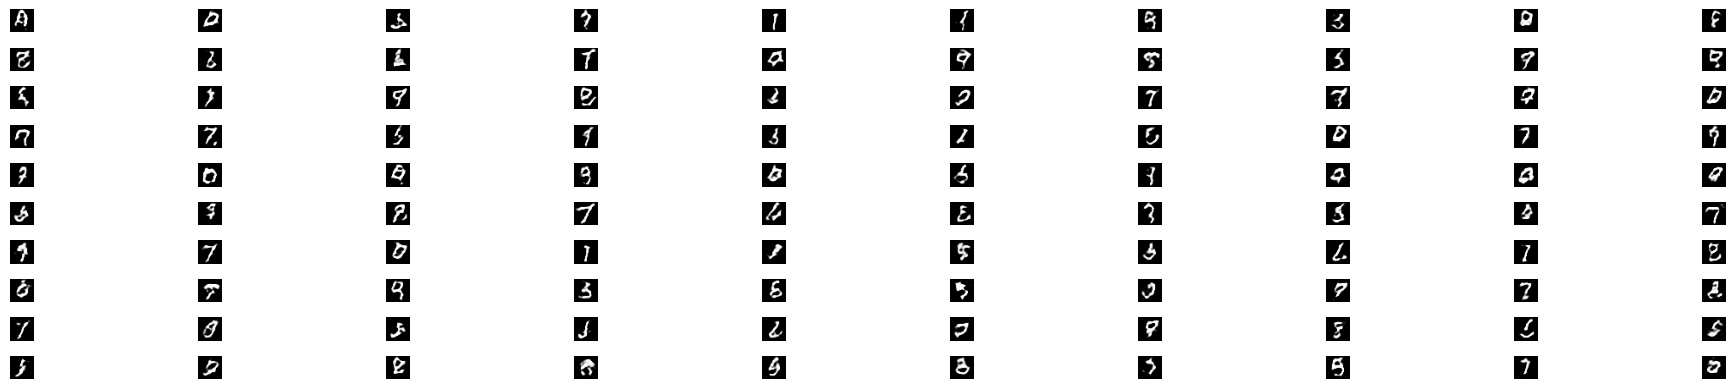

In [ ]:
def display_generated_images(generator, num_examples=10, latent_dim=100, num_classes=10):
    plt.figure(figsize=(20, 4))  # Adjust the figure size if necessary
    for digit in range(num_classes):
        # Generate noise
        noise = tf.random.normal([num_examples, latent_dim])
        # One-hot encode digit labels
        digit_labels = tf.one_hot([digit] * num_examples, depth=num_classes)
        # Concatenate noise and digit labels
        generator_input = tf.concat([noise, digit_labels], axis=1)

        # Generate images
        generated_images = generator(generator_input, training=False)

        # Check if generated_images tensor needs to be converted from logits
        generated_images = tf.sigmoid(generated_images).numpy()

        # Normalize the images to [0, 1] and convert to 'uint8'
        generated_images = np.clip(generated_images * 255, 0, 255).astype('uint8')

        for i in range(num_examples):
            ax = plt.subplot(num_classes, num_examples, digit * num_examples + i + 1)
            plt.imshow(generated_images[i, :, :, 0], cmap='gray')
            plt.axis('off')

    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.show()

# Make sure to replace `latent_dim=100` and `num_classes=10` with your values if they are different.
display_generated_images(generator, num_examples=10, latent_dim=100, num_classes=10)


